
# Diffusion Denoising - Gaussian Noise, Median Filter

**Introduction:**

Diffusion Denoising is a technique used to remove noise from images. It involves adding noise to an image and then training a model to remove it. In the context of images, diffusion noise is a type of noise that is added to an image in a controlled manner to generate a sequence of noisy images. The process progressively blends the image into pure random noise. These noisy images are then used to train a denoising model that can reverse the noise diffusion process and recover the original image from the noisy image. This process is also called "Reverse Diffusion".


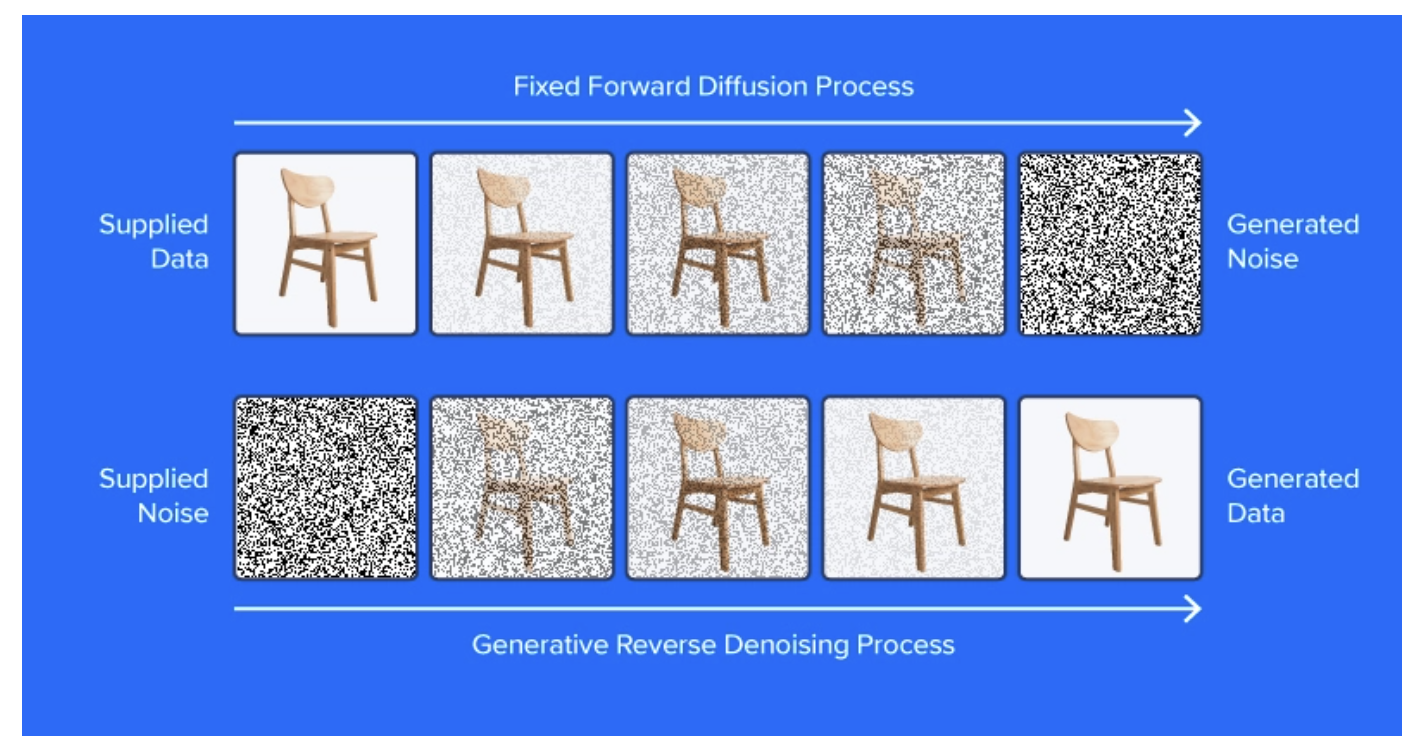

**Gaussian Noise:** A type of random noise that follows a normal (bell-shaped) distribution. It adds random intensity variations to pixels, where most changes are small (near the mean) and extreme changes are rare, similar to static on an old TV screen.The noise intensity and distribution can be controlled by adjusting mean and standard deviation parameters of the Gaussian distribution.

**Gaussian Noise is used for:**
- Testing denoising algorithms
- Evaluating image processing techniques
- Data augmentation in deep learning
- Simulating natural image degradation



**Median Filter:** is a non-linear filtering technique often used for image denoising. It replaces each pixel's value with the median value of its neighboring pixels within a defined window (e.g., a 3x3 grid). This approach is effective in removing salt-and-pepper noise and preserving edges compared to other noise reduction techniques, such as Gaussian blurring.

**Median Filter user for:**

- Removing "salt and pepper" noise (random black and white pixels)
- Preserves edges better than simple blurring
- Removing sudden spikes or unusual values in images
- Commonly used in digital image processing and photography

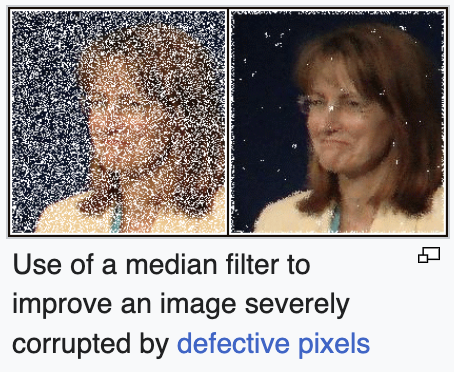

**Explanation of Core Terms in the notebook:**

**Diffusion:** The process of adding noise to an image to create a series of increasingly noisy images.

**Denoising:** The process of removing noise from an image using a trained model.

**Gaussian Noise:** Random noise that follows a normal
distribution.

**Median Filter:** A noise reduction technique using median pixel values within a neighborhood.

**Salt-an-Pepper Noise:** A type of image noise that appears as black and white pixels randomly scattered throughout the image.





## Process of Diffusion Denoising:

**Forward Process (Noise Addition):**

Start with an image: Begin with the original image you want to denoise.

Add noise: Introduce Gaussian noise gradually to the image over multiple time steps.

Noise scheduling: Control the amount of noise at each step using a noise scheduling algorithm.

End with pure noise: After numerous steps, the image becomes heavily dominated by noise.

**Reverse Process (Denoising):**

Start with pure noise: Begin with a noise sample having the same shape as the original image.

Apply Median Filter: Apply the median filter to the noisy image at each time step. The median filter replaces each pixel with the median value of its neighboring pixels, which effectively reduces noise.

Repeat: Repeat the median filtering process for multiple iterations to progressively refine the image and remove more noise.

End with the denoised image: After numerous steps, the repetitive median filtering gradually removes noise and reveals a denoised version of the original image.


**Block diagram of the process:**


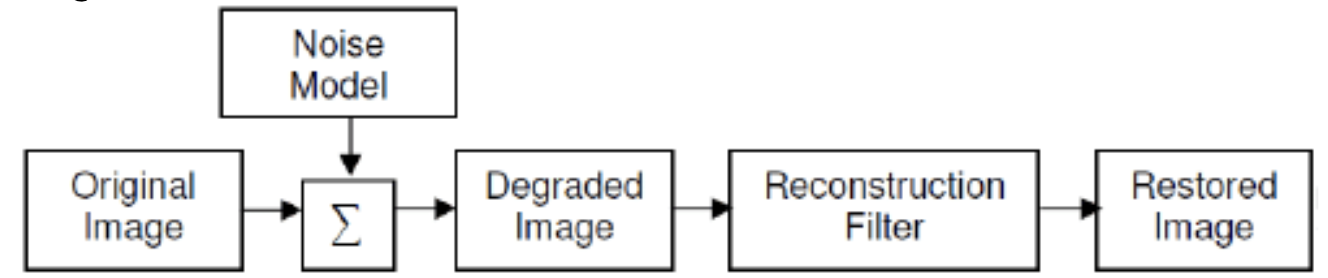

In [1]:
# Importing packages

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data Preprocessing

def preprocess_image(image, label):
    """Preprocess images by normalizing pixel values

    Args:
        image: Input image tensor with pixel values in range [0, 255]
        label: Image label (not used but required for tfds map function)

    Returns:
        Tuple of (processed_image, processed_image) where:
        - Pixel values are normalized to range [0, 1]
        - Returns same image twice since we're using it as both input and target
    """
    # Convert uint8 image to float32 and normalize pixel values to [0,1] range
    image = tf.cast(image, tf.float32) / 255.0

    # Return (input, target) pair where both are the same image
    # This is useful for denoising where we want to recover the original image
    return image, image

In [ ]:
# Noise Addition Functions
# Gaussian Nois
def add_gaussian_noise(image, mean=0, stddev=0.1):
   """Generating random values following bell-shaped pattern (tf.random.normal) and adding them to the original image pixels,
       while keeping values in a valid range [0,1]

   Args:
       image: Input image
       mean: Center of the noise distribution (default=0)
       stddev: Spread of the noise distribution (default=0.1)
   """
   # Generate random noise with same shape as image
   noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)

   # Add noise to image and ensure values stay in [0,1] range
   noisy_image = tf.clip_by_value(image + noise, 0, 1)

   return noisy_image


In [ ]:
# Diffusion Noise
def add_diffusion_noise(image, beta=0.1):
   """Add noise using diffusion process that gradually transforms the image

   Args:
       image: Input image
       beta: Controls noise strength (higher = more noise, default=0.1)
   """
   # Generate random noise with same shape as image
   noise = tf.random.normal(shape=tf.shape(image))

   # Calculate mixing ratio between image and noise
   alpha = 1.0 - beta

   # Mix the original image and noise according to alpha ratio
   noisy_image = tf.sqrt(alpha) * image + tf.sqrt(1.0 - alpha) * noise

   # Ensure values stay in [0,1] range
   noisy_image = tf.clip_by_value(noisy_image, 0, 1)

   return noisy_image, noise

**Approaches to improve median filter performance:**

**Adaptive Filtering:** This technique uses different kernel sizes based on the local noise level in the image. Areas with high noise get processed with larger kernels (like 5x5) for stronger denoising, while areas with less noise use smaller kernels (like 3x3) to preserve details. This balances noise removal and detail preservation.

**Multiple Pass Filtering:** Apply the median filter several times in sequence. The first pass removes the most obvious noise, while subsequent passes clean up remaining artifacts. Start with 2-3 passes, but watch for excessive blurring if too many passes are used.

**Parameter Tuning:** Experiment with different kernel sizes in the median filter. Larger kernels (5x5, 7x7) provide stronger smoothing but may blur edges, while smaller kernels (3x3) preserve details but may leave some noise. Find the balance that works best for your specific noise level.

**Noise Level Adjustment:** Before filtering, try reducing the noise intensity. For diffusion noise, decrease beta from 0.1 to around 0.05. For Gaussian noise, lower the standard deviation to 0.05-0.08. Less severe noise is easier to remove while maintaining image quality.

**Hybrid Methods:** Combine median filtering with other techniques. Try applying a median filter first, then follow with light Gaussian smoothing. Or average the results from different kernel sizes. This can provide better results than using median filtering alone.

In [ ]:
# Median Filter Implementation

def apply_median_filter(image, kernel_size=3):
    """Apply median filter for denoising

    Args:
        image: Input image tensor
        kernel_size: Size of the median filter kernel (default: 3)

    Returns:
        Denoised image tensor
    """
    if len(image.shape) == 2:
        image = tf.expand_dims(image, -1)
    image = tf.expand_dims(image, 0)

    median_vals = tf.nn.depthwise_conv2d(
        input=image,
        filter=tf.ones([kernel_size, kernel_size, 1, 1]),
        strides=[1, 1, 1, 1],
        padding='SAME'
    )

    return tf.squeeze(median_vals)

In [ ]:
# Results Visualizations

def plot_results(original, gaussian_noisy, gaussian_denoised,
               diffusion_noisy, diffusion_denoised):
   """Display 5 images side by side: original, noisy and denoised versions"""
   # Create a wide figure to show all images
   plt.figure(figsize=(15, 3))

   # List of images and their titles to display
   images = [original, gaussian_noisy, gaussian_denoised,
            diffusion_noisy, diffusion_denoised]
   titles = ['Original', 'Gaussian Noise', 'Median Filtered (Gaussian)',
            'Diffusion Noise', 'Median Filtered (Diffusion)']

   # Plot each image with its title
   for i, (img, title) in enumerate(zip(images, titles)):
       plt.subplot(1, 5, i+1)          # Place images in a row
       plt.title(title)                # Add title above image
       plt.imshow(tf.squeeze(img), cmap='gray')  # Show image in grayscale
       plt.axis('off')                 # Hide axis lines

   # Adjust spacing between subplots
   plt.tight_layout()

   # Display the figure
   plt.show()

In [ ]:
# Main Processing Function

def process_images():
   """Load MNIST images, add noise, denoise them, and show results"""
   # Load 5 test images from MNIST dataset
   test_dataset = tfds.load('mnist', split='test', as_supervised=True)
   test_dataset = test_dataset.take(5)

   # Process each image
   for image, _ in test_dataset:
       # Convert image to float and scale pixels to 0-1 range
       image = tf.cast(image, tf.float32) / 255.0

       # Process with Gaussian noise
       gaussian_noisy = add_gaussian_noise(image)             # Add noise
       gaussian_denoised = apply_median_filter(gaussian_noisy)# Remove noise

       # Process with diffusion noise
       diffusion_noisy, _ = add_diffusion_noise(image)       # Add noise
       diffusion_denoised = apply_median_filter(diffusion_noisy)# Remove noise

       # Show original, noisy and denoised images
       plot_results(
           image,                # Original
           gaussian_noisy,       # With Gaussian noise
           gaussian_denoised,    # After removing Gaussian
           diffusion_noisy,      # With diffusion noise
           diffusion_denoised    # After removing diffusion
       )

Processing test images with median filtering...


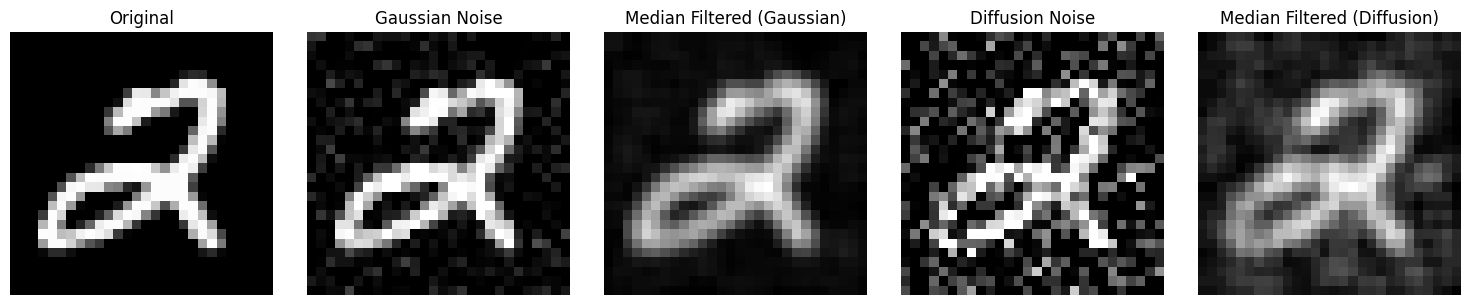

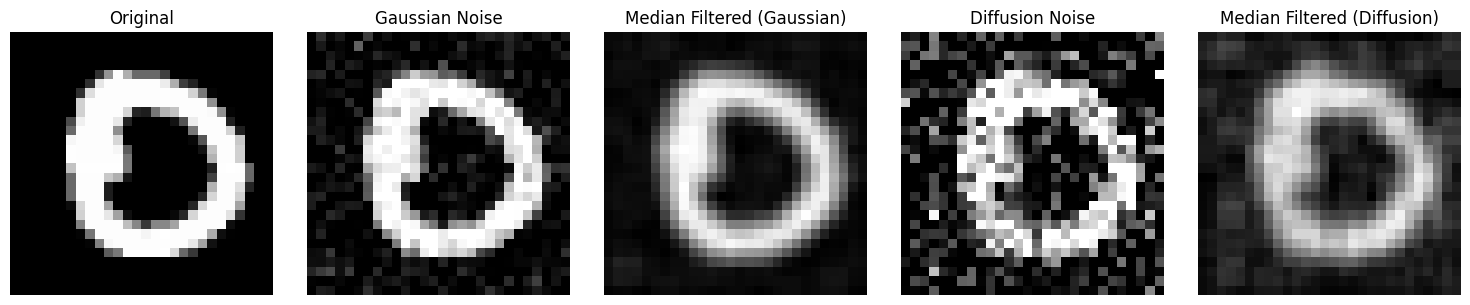

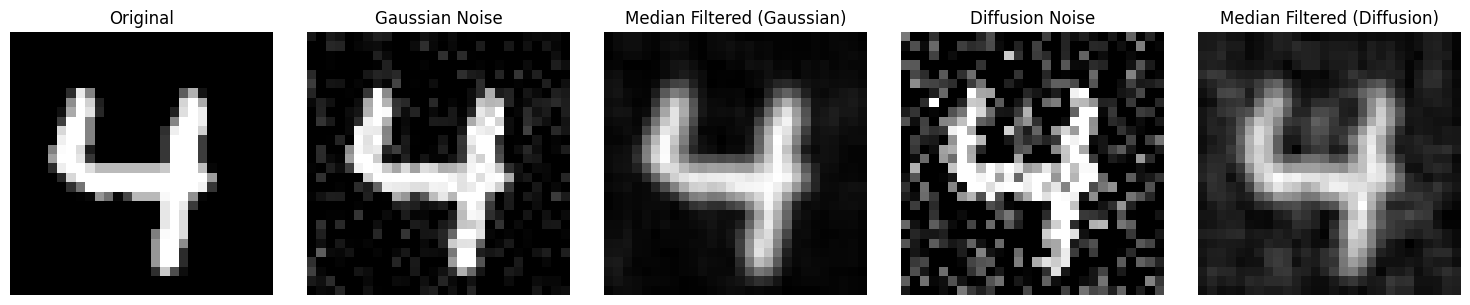

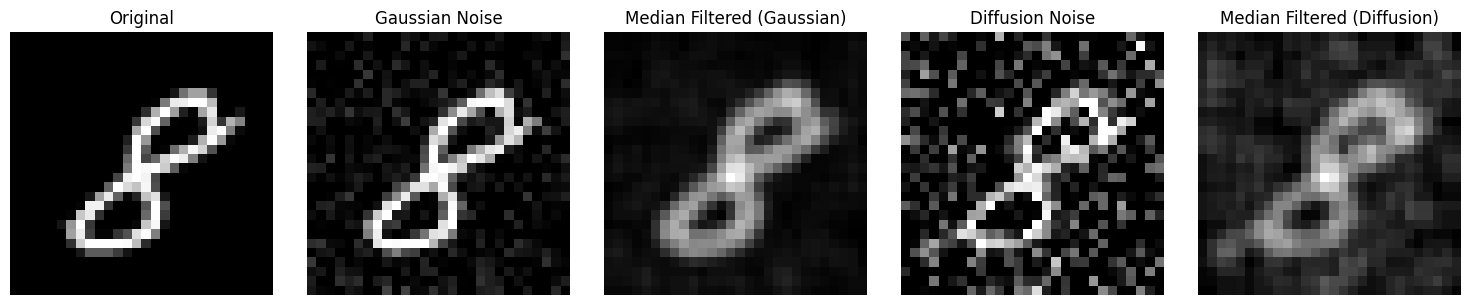

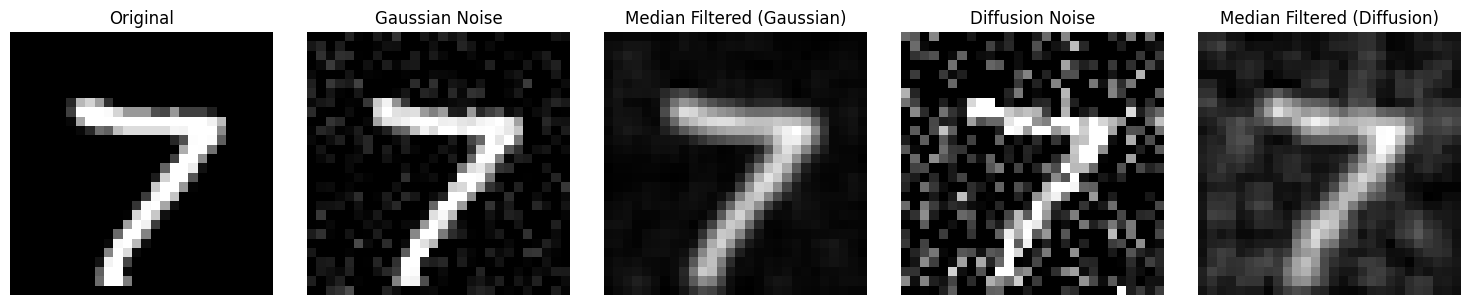

In [ ]:
# Execution

if __name__ == "__main__":
    print("Processing test images with median filtering...")
    process_images()

**Output Interpretation:**

Consider image of "7" - we can see how different types of noise and filtering affect the image quality. The original clear image becomes speckled when Gaussian noise is added, but the median filter handles this well, producing a slightly blurred but recognizable result. However, when diffusion noise is applied, it creates a more structured noise pattern that the median filter struggles to remove effectively. The final filtered result is significantly blurred and barely recognizable, demonstrating that median filtering is much better suited for random Gaussian noise than structured diffusion noise patterns.